1. 先用爬虫程序将 PureVPN 提供的 servers list 爬取下来。

2. 目标网址： https://support.purevpn.com/vpn-servers ，爬取表格中的数据。使用 requests ，BeautifulSoup 。

3. 将爬取到的 servers list 列表添加进之前创建好的MySQL数据库中。使用 pymysql 进行数据库的操作。

4. 利用 tkinter 做人机界面。通过按钮完成
  - 激活自动 ping
  - 显示筛选的服务器地址

In [ ]:
#======   servers 数据库============

# CREATE TABLE `serverslist`.`servers` (
#   `id` INT(11) NOT NULL AUTO_INCREMENT,
#   `RegionName` VARCHAR(45) NULL,
#   `Country` VARCHAR(45) NULL,
#   `City` VARCHAR(45) NULL,
#   `PPTP` VARCHAR(45) NULL,
#   `UDP` FLOAT NULL,
#   `TCP` VARCHAR(45) NULL,
#   PRIMARY KEY (`id`));


#======   ping 数据库============

# CREATE TABLE `serverslist`.`ping` (
#   `id` INT(11) NOT NULL,
#   `maxping` SMALLINT(8) UNSIGNED NULL,
#   `minping` SMALLINT(8) UNSIGNED NULL,
#   `aveping` SMALLINT(8) UNSIGNED NULL,
#   `timeout` INT(32) UNSIGNED NOT NULL DEFAULT 0,
#   `star` INT(32) UNSIGNED NOT NULL DEFAULT 0,
#   PRIMARY KEY (`id`));

In [52]:
import requests
from bs4 import BeautifulSoup as bs
import pymysql.cursors

config={
    'host':'localhost',
    'user':'root',
    'password':'123456',
    'db':'ServersList',
    'charset':'utf8mb4',
    'cursorclass':pymysql.cursors.DictCursor,
    }
conn=pymysql.connect(**config)
    
#=================爬取数据==================
def spider()
    url = 'https://support.purevpn.com/vpn-servers'
    html_doc = requests.get(url).content
    soup = bs(html_doc, 'html.parser')
    table = soup.find('tbody')
    return table('tr')

#================写入SQL====================

def Insert2servers(data):
    try:    
        with conn.cursor() as cursor:
            sql='SELECT * FROM servers WHERE PPTP="%s"'%data[3]
            cursor.execute(sql)
            rs=cursor.fetchall()
            if len(rs) == 0:
                sql='INSERT INTO servers (RegionName,Country,City,PPTP,UDP,TCP) VALUES("%s","%s","%s","%s","%s","%s")'%tuple(data)
                cursor.execute(sql)
                print('succeed ',data[0])
            else:
                print('has data ,skip')
        conn.commit()
    except Exception as e:
        print ("出现问题： " + str(e))


#==============主程序======================
if __name__=='__main__':
    index = spider()
    for r in index:
        data = [_.get_text() for _ in r('td')]
        Insert2servers(data)


succeed  Asia
succeed  Europe
succeed  Africa
succeed  Africa
succeed  South America
succeed  Europe
succeed  North America
succeed  Oceania
succeed  Oceania
succeed  Oceania
succeed  Oceania
succeed  Europe
succeed  Asia
succeed  North America
succeed  Middle East
succeed  Asia
succeed  North America
succeed  Europe
succeed  North America
succeed  North America
succeed  South America
succeed  Europe
succeed  South America
succeed  South America
succeed  Asia
succeed  Europe
succeed  Asia
succeed  North America
succeed  North America
succeed  North America
succeed  Africa
succeed  North America
succeed  South America
succeed  Asia
succeed  Asia
succeed  South America
succeed  North America
succeed  Europe
succeed  North America
succeed  Europe
succeed  Europe
succeed  Europe
succeed  North America
succeed  North America
succeed  South America
succeed  Africa
succeed  North America
succeed  Europe
succeed  Africa
succeed  Europe
succeed  Europe
succeed  Europe
succeed  Europe
succeed  E

In [39]:
import pymysql, os, re, time
from threading import Thread, Lock
from tkinter import *


config={
    'host':'localhost',
    'user':'root',
    'password':'123456',
    'db':'ServersList',
    'charset':'utf8mb4',
    'cursorclass':pymysql.cursors.DictCursor,
    }
conn=pymysql.connect(**config)
mutex = Lock()#创建锁 
thread_count = 0

root = Tk()
root.geometry("700x500+70+0")
root.title("Auto Ping Panel")
text_Input = StringVar()
#================获取地址信息=====================
def getData():
    try:
        with conn.cursor() as cursor:
            sql='select * from servers'
            cursor.execute(sql)
            rs = cursor.fetchall()
            return rs
    except Exception as e:
        print ("getData出现问题： " + str(e))     



#==========将ping的结果返回到数据库中==============
def ist_rs(id,rs):
    try:
        with conn.cursor() as cursor:
            rs=rs[0]
            sql = 'SELECT * FROM ping WHERE id=%s' %id
            cursor.execute(sql)
            result = cursor.fetchall()
            if len(result) == 0:
                sql = 'INSERT INTO ping (id, minping, maxping, aveping) VALUES(%s, %s, %s, %s)' %(id,rs[0],rs[1],rs[2]) 
            else:
                sql= 'UPDATE ping SET minping=%s, maxping=%s, aveping=%s WHERE id=%s' %(rs[0],rs[1],rs[2],id)
#             print(sql)
            cursor.execute(sql)
        conn.commit()
    except Exception as e:
        print ("its_rs出现问题： " + str(e),id)    
    

            
#============若超时，记录 timeout+1 ========================
def add_timeout(id):
    try:
        with conn.cursor() as cursor:
            sql = 'SELECT timeout FROM ping WHERE id=%s' %id
            cursor.execute(sql)
            result = cursor.fetchall()
            if len(result) == 0:
                sql = 'INSERT INTO ping (id, timeout) VALUES(%s, 1)' %id 
            else:
                times = int(result[0]['timeout']) + 1
                sql = 'UPDATE ping SET timeout=%s WHERE id=%s' %(times, id)
#             print(sql)
            cursor.execute(sql)
        conn.commit()
    except Exception as e:
        print ("add_timeout出现问题： " + str(e),id) 
        
#=================对地址进行多线程ping============
def ping_thread(id,ip):
    global thread_count
    ping = 'ping this'.replace('this',ip)
    line = os.popen(ping).read()
    ping_time = re.findall(r"最短 = (\d+)ms，最长 = (\d+)ms，平均 = (\d+)ms", line)
    mutex.acquire()#取得锁 
    if len(ping_time) == 1:
        ist_rs(id,ping_time)
    else:
        add_timeout(id)
    thread_count = thread_count - 1
    mutex.release()#释放锁  
    



def update_ping():
    global thread_count
    urllist = getData()
    if len(urllist) > 0:
        for r in urllist:
            id, ip = r['id'], r['PPTP']
            Thread(target=ping_thread, args=(id,ip)).start()
            thread_count += 1
        while thread_count > 0:
            time.sleep(5)
            tell = 'Threading Ping ....rest(%d)' %thread_count
            print(tell)
            text_Input.set(tell)
    else:
        print('出现问题，请检查server数据库')

#===================GUI============================

def select_servers():
    with conn.cursor() as cursor:
        sql="""select country,city,aveping,PPTP from servers s,ping p
            where s.id=p.id and
            p.timeout=0
            order by p.aveping ASC 
            """
        cursor.execute(sql)
        rs = cursor.fetchall()
        return rs[:10]



def showTop10():
    a = select_servers()
    text_Input.set(a)

def update():
    update_ping()
    showTop10()
    

Tops = Frame(root, width=600, height=90, bg="powder blue", relief=SUNKEN)
Tops.pack(side=TOP)

f1 = Frame(root, width=200, height=400, bg="powder blue", relief=SUNKEN)
f1.pack(side=LEFT)

f2 = Frame(root, width=380, height=400, bg="powder blue", relief=SUNKEN)
f2.pack(side=RIGHT)

lb1Info = Label(Tops, font=('arial', 30, 'bold'), text='Auto Ping', fg='Steel Blue', bd=10, anchor='w' )
lb1Info.grid(row=0, column=0)

btnUpdate = Button(f1, bd=8, fg="black", font=('arial', 10, 'bold' ), text='Update', bg='#D3D3D3',width=10,
              command=update).grid(row=0, column=0)
btnTop10 = Button(f1, pady=3, bd=8, fg="black", font=('arial', 10, 'bold' ), text='Show10', bg='#D3D3D3', width=10,
              command=showTop10).grid(row=1, column=0)
close = Button(f1, pady=3, bd=8, fg="black", font=('arial', 10, 'bold' ), text='QUIT', bg='#D3D3D3',width=10, 
              command=root.destroy).grid(row=2, column=0)

list1 = Listbox(f2, height=400, width=380, listvariable=text_Input)
list1.grid(row=0, column=0)

root.mainloop()


只是搭好骨架，很多地方还有待优化

- update 自动ping所有服务器地址，并将网络状况最优的前10个显示出来
- show10 显示网络状况最优的前10个
- quit 退出程序

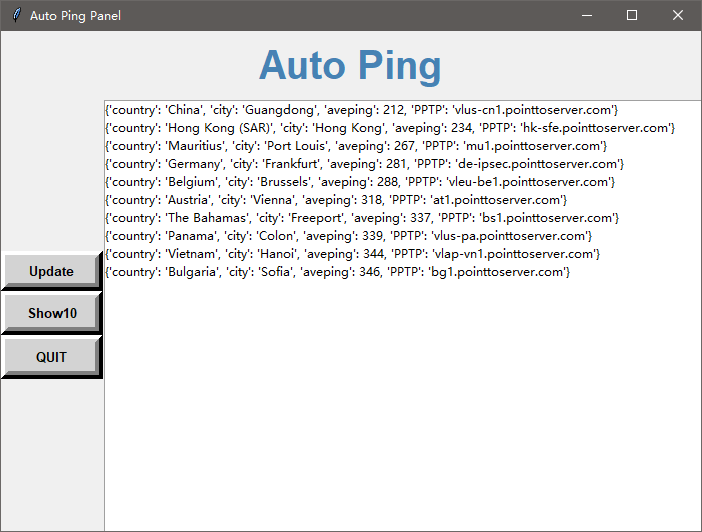